In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import sys
sys.path.append("../BBTRE_physics_analysis/") 

In [7]:
import numpy as np
import xarray as xr

from xmitgcm import open_mdsdataset 
from xhistogram.xarray import histogram

from osse import *
from canyon_utils import *
from sloped_MITgcm import *

### Configuration parameters

In [8]:
# Constant parameters

Γ = 0.0008613659531090722
N = np.sqrt(g*α*Γ)
θ = 1.26E-3
f = -5.3e-5

h = 230
k0 = 5.2e-5
k1 = 1.8e-3

dx = 600.; dy = 600.
delta_t = 15.

### Load output

In [9]:
runname = "run"
data_dir = f"../../MITgcm/experiments/rotated_BBTRE_canyon-tracer/{runname}/"
budget_diags = ["budgetDiag", "tracer01Diag", "tracer02Diag", "tracer03Diag"]
ds = open_mdsdataset(data_dir,ignore_unknown_vars=True,prefix=budget_diags, delta_t=delta_t)
Lx = dx*ds["XC"].size
ds = periodic_extend(ds, ['XC', 'XG'], Lx, [-1,0])
xslice = [500, 500+800]
ds = ds.isel(XC=slice(*xslice), XG=slice(*xslice))
ds, grid = add_rotated_coords(ds, θ)
ds = ds.chunk({'XC': 400, 'XG': 400})
ds['dV'] = (ds.drF * ds.rA * ds.hFacC)

ds = ds.assign_coords({'days': (ds['time'].astype('float64')*1.e-9/86400.) - 5000.*(delta_t/60.)})

ValueError: Resulting object does not have monotonic global indexes along dimension XC

In [ ]:
t = [1., 420.]
ds = ds.isel(time=((ds['days']==t[0]) | (ds['days']==t[1])))

### Reconstructing the full temperature field

In [22]:
ds['THETA'] = ds['THETA'].where(ds['THETA'] != 0.)
ds['THETA_BG_C'] = Γ*ds['Zr']
ds['θ'] = ds['THETA'] + ds['THETA_BG_C']

In [23]:
def add_gradients(ds, v):
    ds[f'd{v}dx'] = grid.interp((
        grid.diff(ds[v], 'X', boundary='periodic').chunk({'XG': 400, 'YC':-1}) /
            ds['dxC']
        ), 'X', boundary='periodic'
    ).chunk({'XC': 400, 'YC':-1})

    ds[f'd{v}dy'] = grid.interp((
            grid.diff(ds[v], 'Y', boundary='periodic').chunk({'XC': 400, 'YG':-1}) /
            ds['dyC']
        ), 'Y', boundary='periodic'
    ).chunk({'XC': 400, 'YC':-1})

    ds[f'd{v}dz'] = grid.interp((
            grid.diff(ds[v], 'Z', boundary='extend').chunk({'XC': 400, 'Zl': -1}) /
            grid.diff(ds['Z'], 'Z', boundary='extend')
        ), 'Z', boundary='extend'
    )

In [36]:
add_gradients(ds, 'θ')
ds = add_hab_coordinates(ds, grid, vert_coord='Z', gridface='C');

### Tracer budgets

First, we evaluate the terms of the tracer and temperature budgets:
\begin{equation}
LHS = RHS = \text{Diffusion} + \text{Advection}
\end{equation}

In [37]:
for tr, tr_name in enumerate(["_TH", "Tr01", "Tr02", "Tr03"]):
    tmp = tracer_flux_budget(ds, grid, tr_name, θ=θ, Γ=Γ).chunk({'Z': -1, 'YC': -1, 'XC': 400})
    if tr_name[0] != "_":
        tr_name = "_"+tr_name
    tmp[f'total_tendency{tr_name}'] = tmp[f'conv_total_flux{tr_name}'].fillna(0.)
    tmp[f'diff_tendency{tr_name}'] = tmp[f'conv_horiz_diff_flux{tr_name}'] + tmp[f'conv_vert_diff_flux{tr_name}']
    tmp[f'adv_tendency{tr_name}'] = tmp[f'conv_horiz_adv_flux{tr_name}'] + tmp[f'conv_vert_adv_flux{tr_name}']
    if tr_name == "_TH":
        tmp[f'adv_tendency{tr_name}'] = tmp[f'adv_tendency{tr_name}'] + tmp['conv_adv_flux_anom_TH']
        tmp[f'diff_tendency{tr_name}'] = tmp[f'diff_tendency{tr_name}'] + tmp['conv_vert_diff_flux_anom_TH']
        tmp[f'total_tendency_truth{tr_name}'] = ds.TOTTTEND * ds['dV'] * day2seconds
    else:
        tmp[f'total_tendency_truth{tr_name}'] = ds[f'Tp_g{tr_name[1:]}'] * ds['dV'] * day2seconds
    ds = xr.merge([ds, tmp])

/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in ar

## Various first moments

In [38]:
for tr in [1, 2, 3]:
    print(f"Computing various 1st moments for Tracer {tr}")
    ds[f'M_Tr0{tr}'] = (ds[f'TRAC0{tr}']*ds['dV']).sum(dim=['Z', 'YC', 'XC']).compute()
    ds[f'Xbar_Tr0{tr}'] = ((ds['XC']*ds[f'TRAC0{tr}']*ds['dV']).sum(dim=['Z', 'YC', 'XC']) / ds[f'M_Tr0{tr}']).compute()
    ds[f'Zbar_Tr0{tr}'] = ((ds['Z']*ds[f'TRAC0{tr}']*ds['dV']).sum(dim=['Z', 'YC', 'XC']) / ds[f'M_Tr0{tr}']).compute()
    ds[f'Zrbar_Tr0{tr}'] = ((ds['Zr']*ds[f'TRAC0{tr}']*ds['dV']).sum(dim=['Z', 'YC', 'XC']) / ds[f'M_Tr0{tr}']).compute()
    ds[f'HABbar_Tr0{tr}'] = ((ds['Z_habC']*ds[f'TRAC0{tr}']*ds['dV']).sum(dim=['Z', 'YC', 'XC']) / ds[f'M_Tr0{tr}']).compute()
    ds[f'θbar_Tr0{tr}'] = ((ds['θ']*ds[f'TRAC0{tr}']*ds['dV']).sum(dim=['Z', 'YC', 'XC']) / ds[f'M_Tr0{tr}']).compute()

Computing various 1st moments for Tracer 1
Computing various 1st moments for Tracer 2
Computing various 1st moments for Tracer 3


## First moment budget (tracer-weighted mean temperature)


The rate of change of the first temperature moment $\overline{\Theta} = \dfrac{\int \Theta c \,\text{d}V}{\int c \; \text{d}V}$ (average temperature of the tracer distribution) is given by

\begin{equation}
\int \partial_{t}  \left( \Theta c \right) \text{d}V + \int \left( c \nabla \cdot \mathbf{u} \Theta + \Theta \nabla \cdot \mathbf{u} c \right) \text{d}V = \int \left( c \nabla \cdot \mathbf{F_{\Theta}} + \Theta \nabla \cdot \mathbf{F_{c}} \right) \text{d}V,
\end{equation}
after dividing by the total tracer mass $M = \int c \; \text{d}V$.
 
In practice, we compute this budget by explicitly reconstructing each of the following terms from the tracer and temperature budgets. Each term is diagnosed from an instantaneous snapshot of the solution at machine precision and we can compare the LHS to the RHS to ensure our budget is closed (this is not guaranteed since the buoyancy and tracer equations are solved separetly).

**Note:** Is hyperdiffusion included in the diffusive diagnostics?

\begin{equation}
\int  \left( \Theta \partial_{t} c + c\partial_{t} \Theta \right) \text{d}V + \int \left( c \nabla \cdot \mathbf{u} \Theta + \Theta \nabla \cdot \mathbf{u} c \right) \text{d}V = \int \left( c \nabla \cdot \mathbf{F_{\Theta}} + \Theta \nabla \cdot \mathbf{F_{c}} \right) \text{d}V
\end{equation}

In practice, we decompose $\Theta = \overline{\Theta} + \Theta'$ where $\partial_{z} \overline{\Theta} = \Gamma$ is a constant lapse rate.

\begin{equation}
\int \left( \left( \overline{\Theta} + \Theta' \right) \partial_{t} c + c \partial_{t} \Theta' \right) \text{d}V +
\int \left( c \nabla \cdot \mathbf{u} \Theta' + cw \Gamma + (\overline{\Theta} + \Theta') \nabla \cdot \mathbf{u} c \right) \text{d}V =
\int \left( c \nabla \cdot \mathbf{F_{\Theta'}} - c \partial_{z} ( \kappa \Gamma) + (\overline{\Theta} + \Theta') \nabla \cdot \mathbf{F_{c}} \right) \text{d}V
\end{equation}

By applying no-flux and no-flow boundary conditions, this equation can be re-written in terms of just the temperature velocity $\omega = \nabla \cdot \left( \kappa \nabla \Theta \right)$,
\begin{equation}
\partial_{t} \overline{\Theta} = 2 \overline{\omega}
\end{equation}

In [39]:
for tr in [1,2,3]:
    print(f"Computing 1st temperature moments for Tracer {tr}")
    ## Tracer mass
    ds[f'M_Tr0{tr}'] = (ds[f'TRAC0{tr}']*ds['dV']).sum(dim=['Z', 'YC', 'XC']).compute()
    
    ## LHS terms
    ds[f'c_dθdt_Tr0{tr}'] = ds[f'TRAC0{tr}'] * (ds['TOTTTEND']* day2seconds) * ds['dV']
    ds[f'θ_dcdt_Tr0{tr}'] = ds['θ'] * ds[f'Tp_gTr0{tr}'] * ds['dV']

    ## Full LHS
    ds[f'd(θbar)dt_Tr0{tr}'] = (
        (ds[f'c_dθdt_Tr0{tr}'].sum(dim=['Z', 'YC', 'XC']) / ds[f'M_Tr0{tr}']).compute() +
        (ds[f'θ_dcdt_Tr0{tr}'].sum(dim=['Z', 'YC', 'XC']) / ds[f'M_Tr0{tr}']).compute()
    )
    
    ## RHS terms
    # Advective terms
    ds[f'c_div_uθ_Tr0{tr}'] = ds[f'TRAC0{tr}']*ds['adv_tendency_TH']
    ds[f'θ_div_uc_Tr0{tr}'] = ds['θ']*ds[f'adv_tendency_Tr0{tr}']

    ds[f'd(θbar)dt_ADV_Tr0{tr}'] = (
        (ds[f'c_div_uθ_Tr0{tr}'].sum(dim=['Z', 'YC', 'XC']) / ds[f'M_Tr0{tr}']).compute() +
        (ds[f'θ_div_uc_Tr0{tr}'].sum(dim=['Z', 'YC', 'XC']) / ds[f'M_Tr0{tr}']).compute()
    )
    
    # Diffusive terms
    ds[f'c_div_Fθ_Tr0{tr}'] = ds[f'TRAC0{tr}']*ds['diff_tendency_TH']
    ds[f'θ_div_Fc_Tr0{tr}'] = ds['θ']*ds[f'diff_tendency_Tr0{tr}']

    ds[f'd(θbar)dt_DIFF_Tr0{tr}'] = (
        (ds[f'c_div_Fθ_Tr0{tr}'].sum(dim=['Z', 'YC', 'XC']) / ds[f'M_Tr0{tr}']).compute() + 
        (ds[f'θ_div_Fc_Tr0{tr}'].sum(dim=['Z', 'YC', 'XC']) / ds[f'M_Tr0{tr}']).compute()
    )
    
    # Full RHS
    ds[f'd(θbar)dt_RHS_Tr0{tr}'] = ds[f'd(θbar)dt_DIFF_Tr0{tr}'] + ds[f'd(θbar)dt_ADV_Tr0{tr}']
    
    # Buoyancy velocity term
    ds[f'ωbar_Tr0{tr}'] = ((ds['diff_tendency_TH'] * ds[f'TRAC0{tr}']).sum(dim=['Z', 'YC', 'XC']) / ds[f'M_Tr0{tr}']).compute()
    ds[f'2ω_Tr0{tr}'] = 2*ds[f'ωbar_Tr0{tr}']

Computing 1st temperature moments for Tracer 1


/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Computing 1st temperature moments for Tracer 2


/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Computing 1st temperature moments for Tracer 3


/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


In [65]:
for tr in [1,2,3]:
    print(f"Approximating 1st temperature moments for Tracer {tr}")
    ds1 = ds.isel(time=(ds['days']==t[1])).squeeze()
    ds0 = ds.isel(time=(ds['days']==t[0])).squeeze()
    Δt = ((ds['time'][1] - ds['time'][0])*1e-9).astype('float64')
    ds[f'd(θc)dt_Tr0{tr}'] = (ds1[f"TRAC0{tr}"]*ds1[f"θ"] - ds0[f"TRAC0{tr}"]*ds0[f"θ"])/Δt * ds['dV']
    ds[f'd(θbar)dt_LHS-approx_Tr0{tr}'] = (ds[f'd(θc)dt_Tr0{tr}'].sum(dim=['Z', 'YC', 'XC']) / ds[f'M_Tr0{tr}'].isel(time=0).squeeze()).compute()

Approximating 1st temperature moments for Tracer 1
Approximating 1st temperature moments for Tracer 2
Approximating 1st temperature moments for Tracer 3


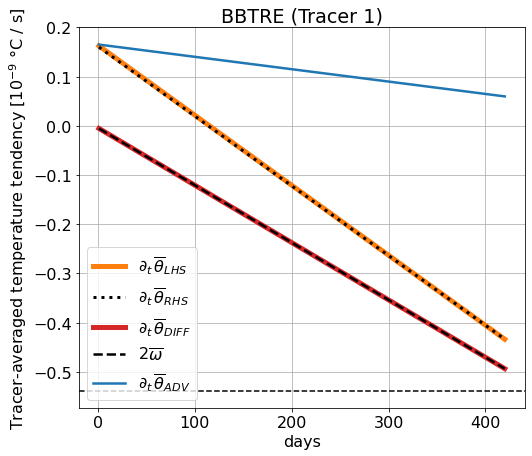

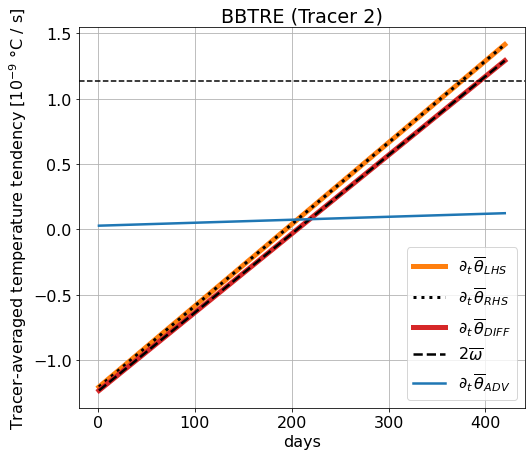

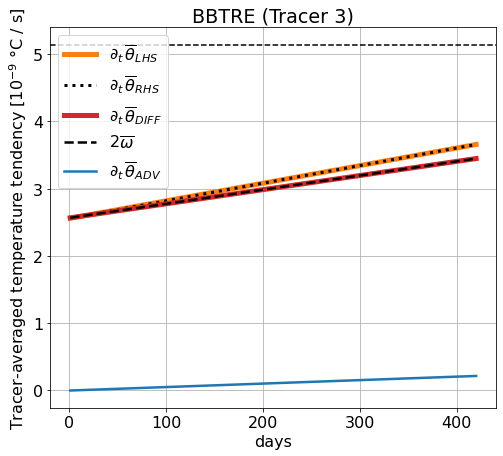

In [75]:
for tr in [1, 2, 3]:
    plt.figure(figsize=(8,7))
    (1e9*ds[f'd(θbar)dt_Tr0{tr}']).plot(x='days', linestyle="-", color="C1", lw=5, label=r"$\partial_{t}\, \overline{\theta}_{LHS}$")
    (1e9*ds[f'd(θbar)dt_RHS_Tr0{tr}']).plot(x='days', linestyle=":", color="k", lw=3, label=r"$\partial_{t}\, \overline{\theta}_{RHS}$")
    (1e9*ds[f'd(θbar)dt_DIFF_Tr0{tr}']).plot(x='days', color="C3", lw=5, label=r"$\partial_{t}\, \overline{\theta}_{DIFF}$")
    (1e9*ds[f'2ω_Tr0{tr}']).plot(x='days', linestyle="--", color="k",lw=2.5, label=r"$2\overline{\omega}$")
    (1e9*ds[f'd(θbar)dt_ADV_Tr0{tr}']).plot(x='days', color="C0", lw=2.5, linestyle="-", label=r"$\partial_{t}\, \overline{\theta}_{ADV}$")
    plt.axhline(1e9*ds[f'd(θbar)dt_LHS-approx_Tr0{tr}'].values, color="k", ls="--")
    plt.legend()
    plt.ylabel(r"Tracer-averaged temperature tendency [10$^{-9}$ $\degree$C / s]")
    plt.grid(True)
    plt.title(f"BBTRE (Tracer {tr})")

## Second moment budget (tracer-weighted centered temperature variance)

The rate of change of the *second* temperature moment $\overline{\Theta^{2}} = \dfrac{\int \Theta^{2} c \,\text{d}V}{\int c \; \text{d}V}$ (average temperature variance of the tracer distribution) is given by

\begin{equation}
\int \partial_{t}  \left( \Theta c \right) \text{d}V + \int \left( c \nabla \cdot \mathbf{u} \Theta + \Theta \nabla \cdot \mathbf{u} c \right) \text{d}V = \int \left( c \nabla \cdot \mathbf{F_{\Theta}} + \Theta \nabla \cdot \mathbf{F_{c}} \right) \text{d}V,
\end{equation}
after dividing by the total tracer mass $M = \int c \; \text{d}V$.
 
In practice, we compute this budget by explicitly reconstructing each of the following terms from the tracer and temperature budgets. Each term is diagnosed from an instantaneous snapshot of the solution at machine precision and we can compare the LHS to the RHS to ensure our budget is closed (this is not guaranteed since the buoyancy and tracer equations are solved separetly).

**Note:** Is hyperdiffusion included in the diffusive diagnostics?

\begin{equation}
\int  \left( \Theta \partial_{t} c + c\partial_{t} \Theta \right) \text{d}V + \int \left( c \nabla \cdot \mathbf{u} \Theta + \Theta \nabla \cdot \mathbf{u} c \right) \text{d}V = \int \left( c \nabla \cdot \mathbf{F_{\Theta}} + \Theta \nabla \cdot \mathbf{F_{c}} \right) \text{d}V
\end{equation}

In practice, we decompose $\Theta = \overline{\Theta} + \Theta'$ where $\partial_{z} \overline{\Theta} = \Gamma$ is a constant lapse rate.

\begin{equation}
\int \left( \left( \overline{\Theta} + \Theta' \right) \partial_{t} c + c \partial_{t} \Theta' \right) \text{d}V +
\int \left( c \nabla \cdot \mathbf{u} \Theta' + cw \Gamma + (\overline{\Theta} + \Theta') \nabla \cdot \mathbf{u} c \right) \text{d}V =
\int \left( c \nabla \cdot \mathbf{F_{\Theta'}} - c \partial_{z} ( \kappa \Gamma) + (\overline{\Theta} + \Theta') \nabla \cdot \mathbf{F_{c}} \right) \text{d}V
\end{equation}

By applying no-flux and no-flow boundary conditions, this equation can be re-written in terms of just the temperature velocity $\omega = \nabla \cdot \left( \kappa \nabla \Theta \right)$,
\begin{equation}
\partial_{t} \overline{\Theta} = 2 \overline{\omega}
\end{equation}

In [104]:
for tr in [1,2,3]:
    print(f"Computing 2nd moments for Tracer {tr}")
    
    ## LHS terms
    ds[f'2cθ_dθdt_Tr0{tr}'] = (2*ds[f'TRAC0{tr}']*ds['θ']) * (ds['TOTTTEND']* day2seconds) * ds['dV']
    ds[f'θ**2_dcdt_Tr0{tr}'] = ds['θ']**2 * (ds[f'Tp_gTr0{tr}'] * ds['dV'])
    ds[f'd(θbar**2)dt_Tr0{tr}'] = 2*ds[f'θbar_Tr0{tr}']*ds[f'd(θbar)dt_Tr0{tr}']
    
    ## Full LHS
    ds[f'd(θ**2bar)dt_Tr0{tr}'] = (
        (ds[f'2cθ_dθdt_Tr0{tr}'].sum(dim=['Z', 'YC', 'XC']) / ds[f'M_Tr0{tr}']).compute() +
        (ds[f'θ**2_dcdt_Tr0{tr}'].sum(dim=['Z', 'YC', 'XC']) / ds[f'M_Tr0{tr}']).compute()
    )
    
    # Centered Full LHS
    ds[f'd((θ-θbar)**2)bardt_Tr0{tr}'] = ds[f'd(θ**2bar)dt_Tr0{tr}'] - ds[f'd(θbar**2)dt_Tr0{tr}']
    
    # Gradients
    ds['Gradθ**2'] = ds['dθdx']**2 + ds['dθdy']**2 + ds[f'dθdz']**2
    ds[f'Gradθ**2bar_Tr0{tr}'] = ((ds['Gradθ**2']*ds[f'TRAC0{tr}']*ds['dV']).sum(['Z', 'YC', 'XC']) / ds[f'M_Tr0{tr}']).compute()
    
    ## In-situ diffusivity
    ds["κ"] = grid.interp(ds['KVDIFF'], 'Z', boundary='extend')
    ds[f"κbar_Tr0{tr}"] = ((ds["κ"]*ds[f'TRAC0{tr}']*ds['dV']).sum(['Z', 'YC', 'XC']) / ds[f'M_Tr0{tr}']).compute()
    
    ## Taylor diffusivity
    ds[f'κGradθ**2bar_Tr0{tr}'] = ((ds['κ']*ds['Gradθ**2']*ds[f'TRAC0{tr}']*ds['dV']).sum(['Z', 'YC', 'XC']) / ds[f'M_Tr0{tr}']).compute()
    ds[f"κTaylor_Tr{tr}"] = ds[f'κGradθ**2bar_Tr0{tr}']/ds[f'Gradθ**2bar_Tr0{tr}']
    
    #### Buoyancy-velocity correlation term
    ds[f"θbar_Tr0{tr}"] = ((ds['θ']*ds[f'TRAC0{tr}']*ds['dV']).sum(dim=['Z', 'YC', 'XC']) / ds[f'M_Tr0{tr}']).compute()
    ds[f"ωbarθbar_Tr0{tr}"] = ds[f'ωbar_Tr0{tr}']*ds[f'θbar_Tr0{tr}']
    ds[f"_(ωθ)bar_Tr0{tr}"] = (((ds['diff_tendency_TH']*ds['θ']) * ds[f'TRAC0{tr}']).sum(dim=['Z', 'YC', 'XC']) / ds[f'M_Tr0{tr}']).compute()
    ds[f"_(ωpθp)bar_Tr0{tr}"] = ds[f"_(ωθ)bar_Tr0{tr}"] - ds[f"ωbarθbar_Tr0{tr}"]
     
    ## Omega diffusivity
    ds[f"κOmega_Tr0{tr}"] = 2*ds[f"_(ωpθp)bar_Tr0{tr}"]/ds[f'Gradθ**2bar_Tr0{tr}']
        
    ## Bulk tracer diffusivity
    ds[f'κTracer_Tr0{tr}'] = 0.5*ds[f'd((θ-θbar)**2)bardt_Tr0{tr}']/ds[f'Gradθ**2bar_Tr0{tr}']


Computing 2nd moments for Tracer 1


/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Computing 2nd moments for Tracer 2


/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Computing 2nd moments for Tracer 3


/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


In [87]:
saving = ds.copy()

saving['time'].dims
for dv in list(saving.data_vars)+list(saving.coords):
    if (saving[dv].dims != ('time',)) & (saving[dv].dims != ()):
        saving = saving.drop_vars([dv])
        
saving.to_netcdf("../../data/BBTRE-tracer/time-approx_tracer_moments.nc", mode='w')